In [149]:
#%pip install numpy pandas matplotlib scikit-learn tensorflow seaborn


In [150]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [151]:
#df1 = pd.read_csv("../../data/dev101_prepared.csv")
#df2 = pd.read_csv("../../data/dev102_prepared.csv")

#df_all = pd.concat([df1, df2], ignore_index=True)
df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values(by='timestamp').reset_index(drop=True)
df_all

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,soil_diff,geo_diff
0,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010,6.599998,11.209480
1,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933,-6.599998,0.233375
2,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010,6.599998,-0.092939
3,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933,-6.599998,-11.430505
4,2025-05-02 11:42:28.667259,101.0,28.900000,0.0,34.250019,62.839169,15.995875,8.637998,99.899010,6.699999,12.753070
...,...,...,...,...,...,...,...,...,...,...,...
301185,2025-06-29 20:25:27.980000,101.0,27.900000,0.0,29.101625,81.113754,2.490953,8.638010,99.898972,2.299999,-0.185184
301186,2025-06-29 20:25:48.980000,102.0,25.600000,0.0,29.908064,77.426796,3.856516,8.637931,99.898941,-2.299999,1.365563
301187,2025-06-29 20:26:01.100000,102.0,25.600000,0.0,29.349968,80.005569,2.614293,8.637931,99.898949,0.000000,-1.242223
301188,2025-06-29 20:26:02.150000,101.0,27.900000,0.0,29.050890,81.302589,8.617684,8.638011,99.898972,2.299999,6.003392


In [152]:
print(df_all['devID'].value_counts())

devID
102.0    151583
101.0    149607
Name: count, dtype: int64


In [153]:
# Feature ที่จะใช้
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']

# สร้าง Scaler และฟิตข้อมูล
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_all[numerical_cols])

# เพิ่มคอลัมน์ scaled กลับเข้า DataFrame
for i, col in enumerate(numerical_cols):
    df_all[f'scaled_{col}'] = scaled_values[:, i]

# Save scaler (สำหรับใช้งานจริงในอนาคต)
joblib.dump(scaler, 'scaler2.save')


['scaler2.save']

In [154]:
SEQUENCE_LENGTH = 30

def create_sequences_by_device(df, sequence_length, numerical_cols):
    sequences = []
    device_ids = []
    timestamps = []

    for dev_id, group in df.groupby('devID'):
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values

        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1])  

    return np.array(sequences), device_ids, timestamps

X_seq, device_ids, seq_timestamps = create_sequences_by_device(df_all, SEQUENCE_LENGTH, numerical_cols)


In [155]:
n = len(X_seq)
train_size = int(n * 0.7)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

X_train = X_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]
X_test = X_seq[train_size + val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (210792, 30, 7), Val: (60226, 30, 7), Test: (30114, 30, 7)


In [156]:
n_features = len(numerical_cols)
input_shape = (SEQUENCE_LENGTH, n_features)

encoder_inputs = Input(shape=input_shape)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoder_inputs)
decoded = RepeatVector(SEQUENCE_LENGTH)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

model = Model(encoder_inputs, decoded)
model.compile(optimizer=Adam(0.001), loss='mse')

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 7)          │           231 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,671 (53.40 KB)

 Trainable params: 13,671 (53.40 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, #90
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save model
model.save('lstm_autoencoder_model2.h5')

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss During Training')
plt.grid(True)
plt.show()


Epoch 1/100
4379/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0203

In [ ]:
# Predict test set
X_test_pred = model.predict(X_test)
test_reconstruction_error = np.mean(np.mean(np.square(X_test - X_test_pred), axis=1), axis=1)

# แสดงค่า loss บน test set
test_loss = np.mean(test_reconstruction_error)
print(f"Test Reconstruction Loss: {test_loss}")


942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Test Reconstruction Loss: 0.0023391155965740654


# Test

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA

df_test = pd.read_csv('../../data/devAll2_prepared.csv')
df_original_features = df_test.copy() 

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)

scaler = joblib.load('scaler2.save')
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']

missing_cols = [col for col in numerical_cols if col not in df_test.columns]
if missing_cols:
    raise ValueError(f"Missing columns in input CSV: {missing_cols}")

scaled_values = scaler.transform(df_test[numerical_cols])
for i, col in enumerate(numerical_cols):
    df_test[f'scaled_{col}'] = scaled_values[:, i]

# === sequence for predict ===
SEQUENCE_LENGTH = 30

def create_sequences(df, sequence_length, numerical_cols):
    sequences, device_ids, timestamps = [], [], []
    # เก็บ index เริ่มต้นของแต่ละ sequence เพื่อเชื่อมโยงกับ df_test
    start_indices = []

    for dev_id, group in df.groupby('devID'):
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        
        # เพิ่มคอลัมน์ original_index เพื่อให้สามารถเชื่อมโยงกลับไปยัง df_test ได้
        group = group.reset_index(drop=False).rename(columns={'index': 'original_df_index'})

        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1]) # timestamp ของจุดสุดท้ายใน sequence
            start_indices.append(group['original_df_index'].iloc[i + sequence_length - 1]) # เก็บ original index ของจุดสุดท้าย

    return np.array(sequences), device_ids, timestamps, start_indices

# สร้าง sequence
X_seq_test, device_ids_test, timestamps_test, start_indices_test = create_sequences(df_test, SEQUENCE_LENGTH, numerical_cols)

# === 5. โหลดโมเดลและ predict ===
model = load_model('lstm_autoencoder_model2.h5', compile=False)
X_pred = model.predict(X_seq_test)

# === 6. คำนวณ reconstruction error ===
reconstruction_error = np.mean(np.mean(np.square(X_seq_test - X_pred), axis=1), axis=1)

# === 7. สร้าง DataFrame เก็บผล ===
df_results = pd.DataFrame({
    'devID': device_ids_test,
    'timestamp': timestamps_test,
    'reconstruction_error': reconstruction_error,
    'original_df_index': start_indices_test # เพิ่มคอลัมน์นี้เพื่อ merge กับ df_original_features
})

# === 8. คำนวณ thresholds และกำหนด Anomaly Level ===
threshold_warning = 0.01
threshold_critical = 0.0225

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'

df_results['anomaly_level'] = df_results['reconstruction_error'].apply(classify_anomaly)

print(f"95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"99th percentile (Critical) threshold = {threshold_critical:.5f}")
print("\n--- Anomaly Level Counts ---")
print(df_results['anomaly_level'].value_counts())

9411/9411 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step
95th percentile (Warning) threshold = 0.01000
99th percentile (Critical) threshold = 0.02250

--- Anomaly Level Counts ---
anomaly_level
normal      292784
warning       8289
critical        59
Name: count, dtype: int64


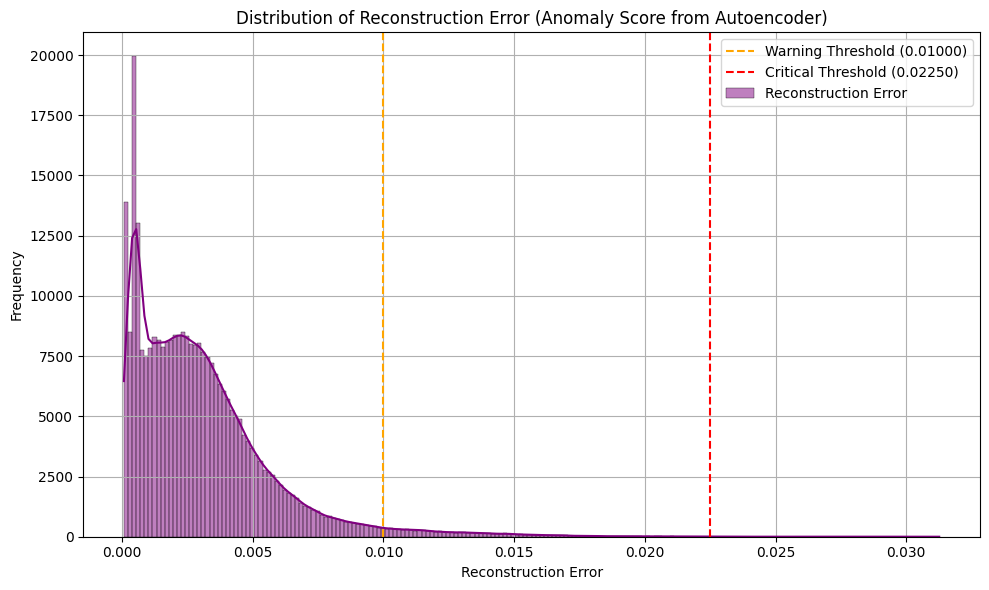

In [ ]:
# --- การรวมข้อมูลเพื่อการวิเคราะห์เพิ่มเติม ---
# เราจะ merge df_results กับ df_original_features โดยใช้ 'original_df_index'
# เพื่อให้มีคอลัมน์ features เดิมที่ไม่ถูก scale อยู่ใน DataFrame เดียวกัน
# สร้างคอลัมน์ 'index' ใน df_original_features ให้ตรงกับ 'original_df_index'
# Remove duplicate columns in df_original_features (keep only one 'original_df_index')
df_original_features = df_original_features.loc[:, ~df_original_features.columns.duplicated()]

# Ensure 'original_df_index' exists and is unique
if 'original_df_index' not in df_original_features.columns:
    df_original_features = df_original_features.reset_index().rename(columns={'index': 'original_df_index'})

# Convert timestamp to datetime64[ns] for merge compatibility
df_original_features['timestamp'] = pd.to_datetime(df_original_features['timestamp'])

# Merge ข้อมูล
df_analysis = pd.merge(df_results, df_original_features, on=['devID', 'timestamp', 'original_df_index'], how='left')

# ตรวจสอบว่ามีค่า NaN หลังจาก Merge หรือไม่ (ถ้ามี แสดงว่า timestamp/devID ไม่ตรงกันพอดี)
if df_analysis.isnull().any().any():
    print("\nWarning: Missing values found in merged DataFrame. Ensure timestamps and devIDs match for accurate feature analysis.")

# --- เริ่มการสร้าง Visualization ---
# ตั้งค่า palette สำหรับ Anomaly Levels
palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

# --- 1. Distribution of Reconstruction Error ---
plt.figure(figsize=(10, 6))
sns.histplot(df_results['reconstruction_error'], bins=200, kde=True, color='purple', label='Reconstruction Error')
plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Distribution of Reconstruction Error (Anomaly Score from Autoencoder)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\4259196113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)


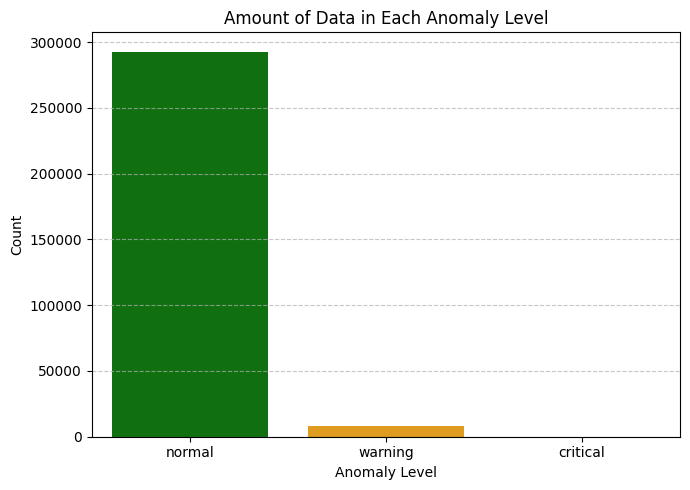

In [ ]:
# --- 2. Anomaly Level Counts ---
plt.figure(figsize=(7, 5))
sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
plt.title('Amount of Data in Each Anomaly Level')
plt.xlabel('Anomaly Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

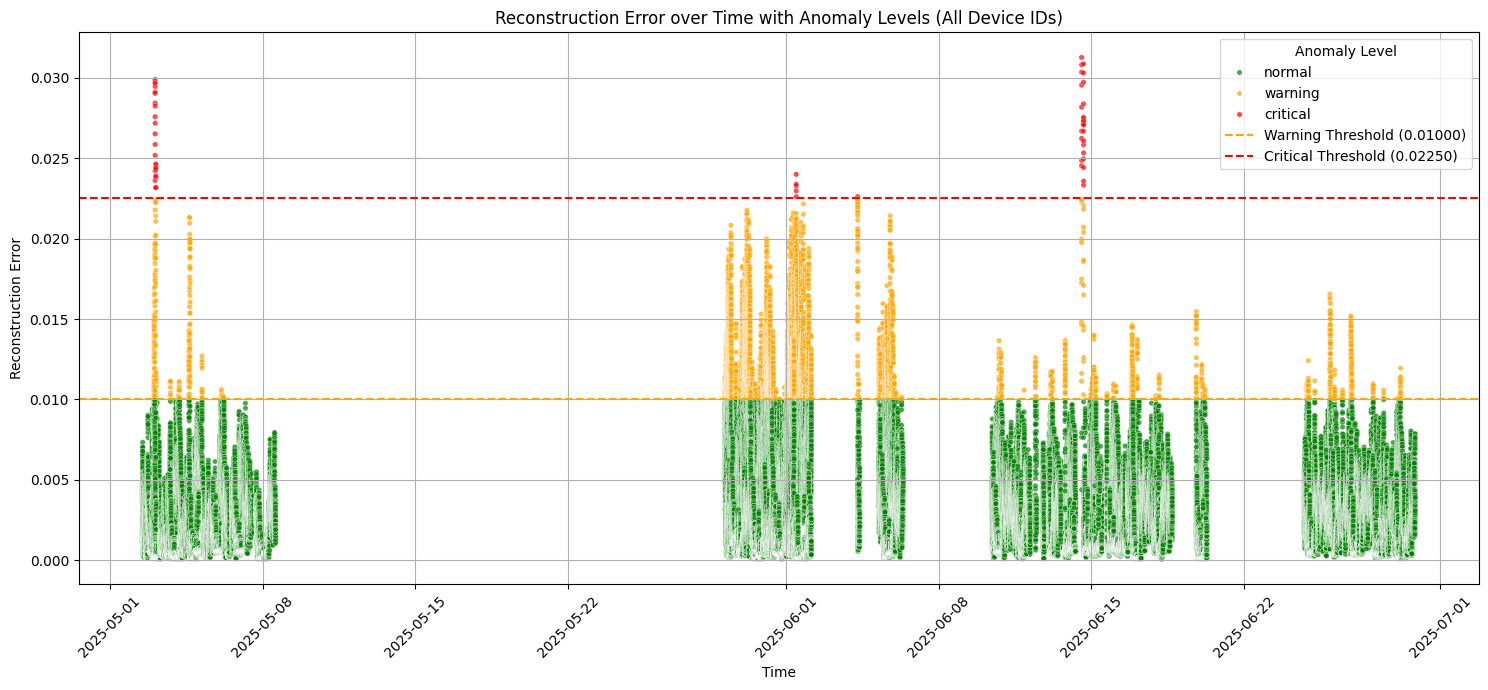

In [ ]:
# --- 3. Reconstruction Error Over Time with Anomaly Levels (All Devices) ---
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results, x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (All Device IDs)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()


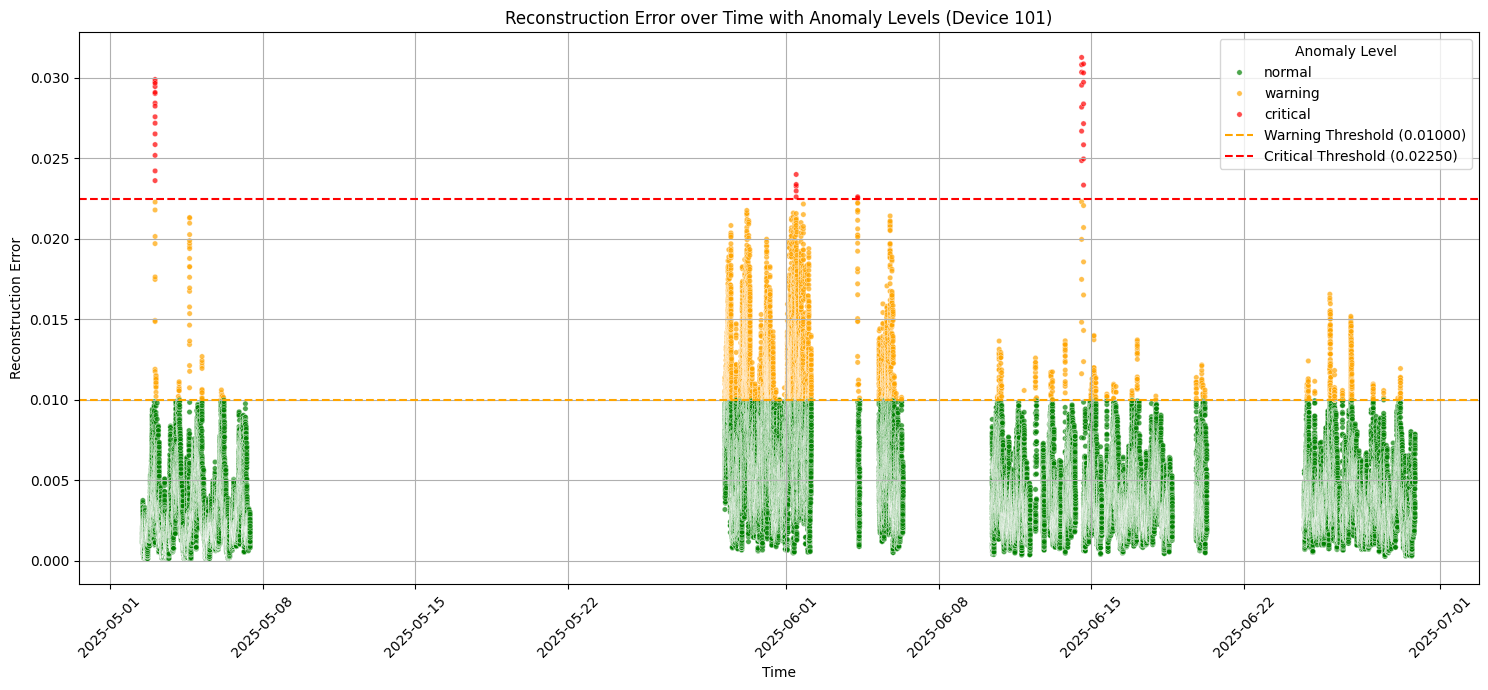

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results[df_results['devID'] == 101.0], 
    x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (Device 101)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()


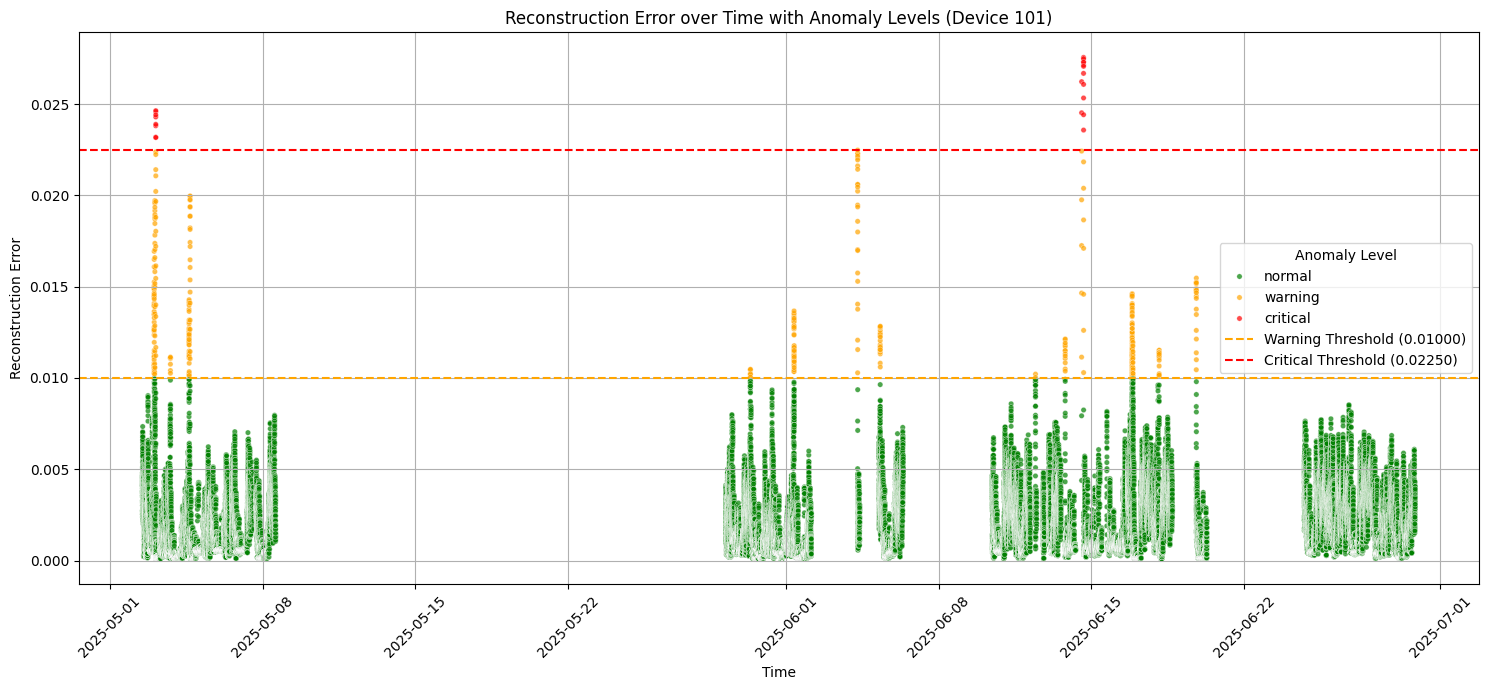

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results[df_results['devID'] == 102.0], 
    x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (Device 101)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()



--- Box Plots of Original Features by Anomaly Level (with Mean & Count) ---


C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


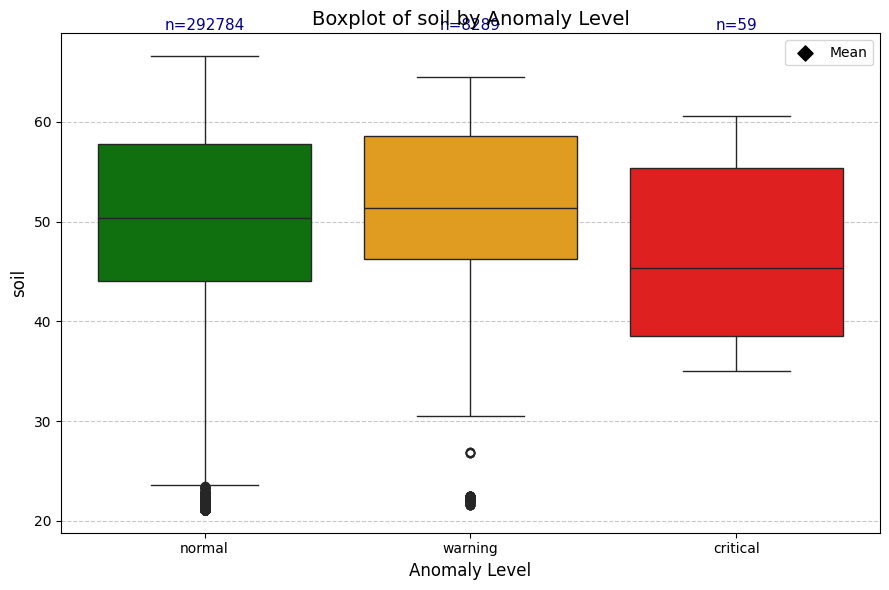

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


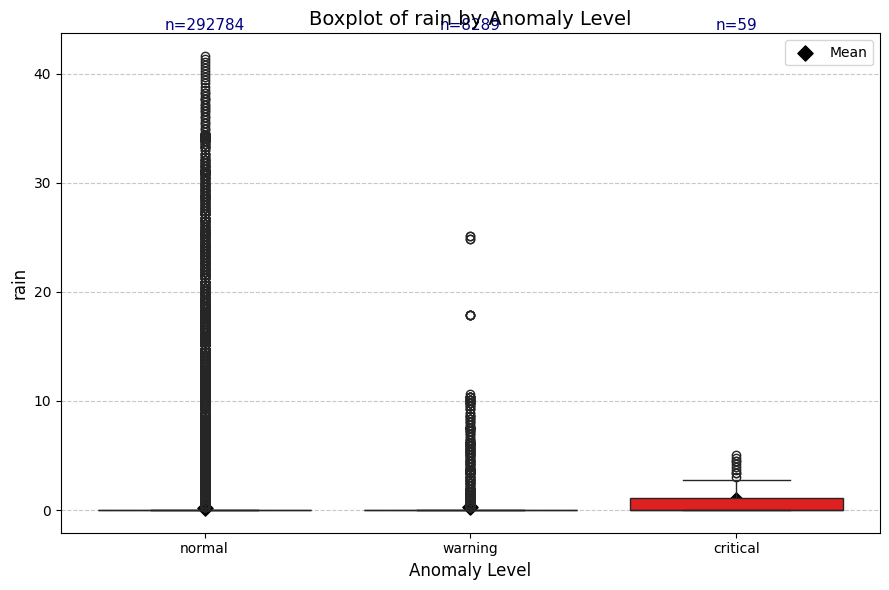

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


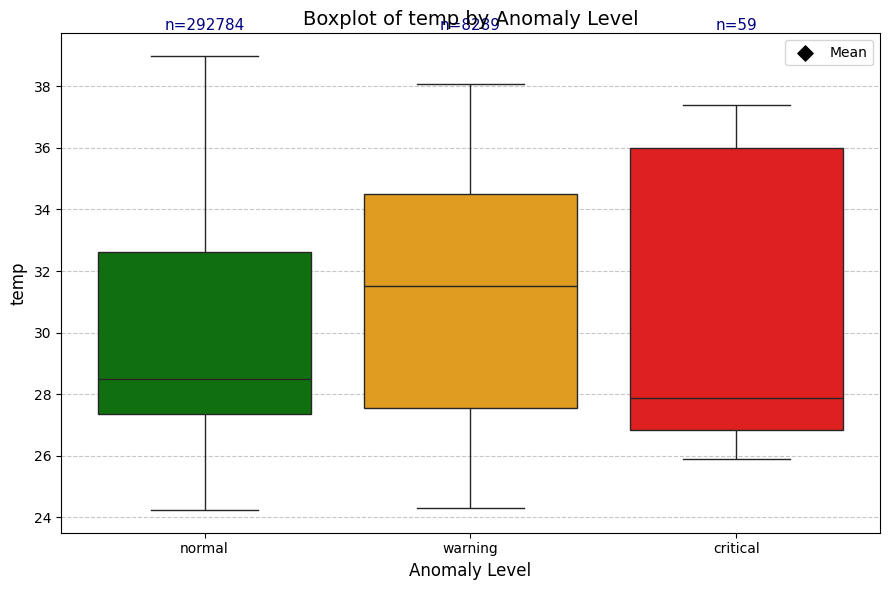

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


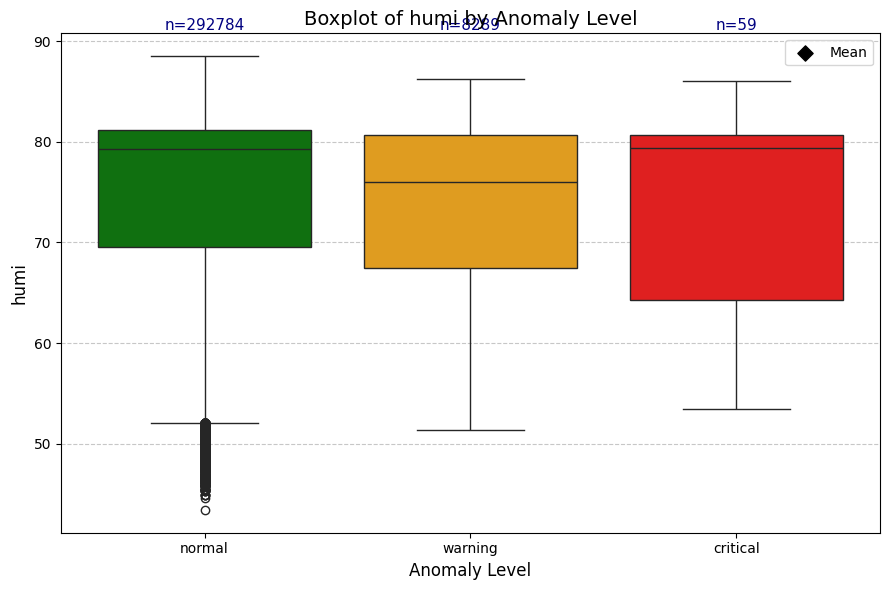

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


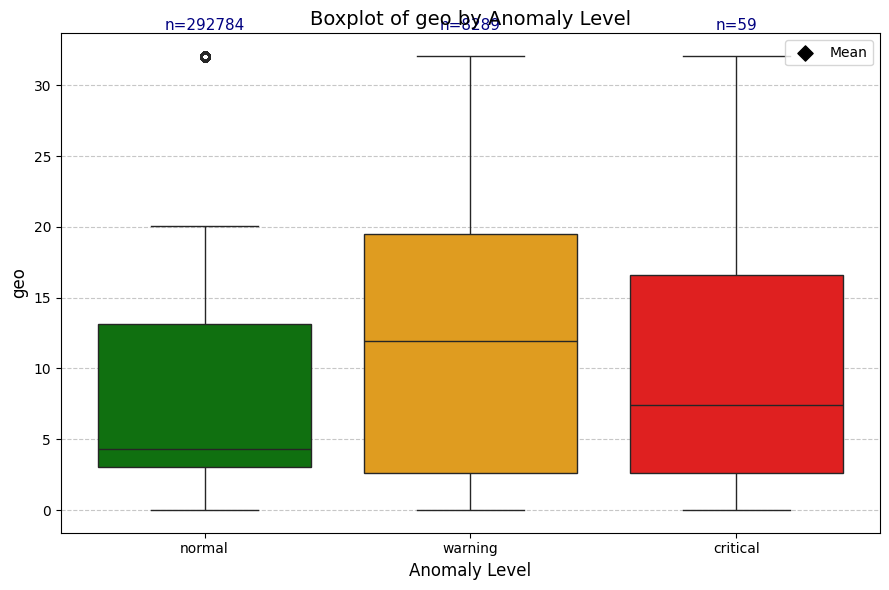

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


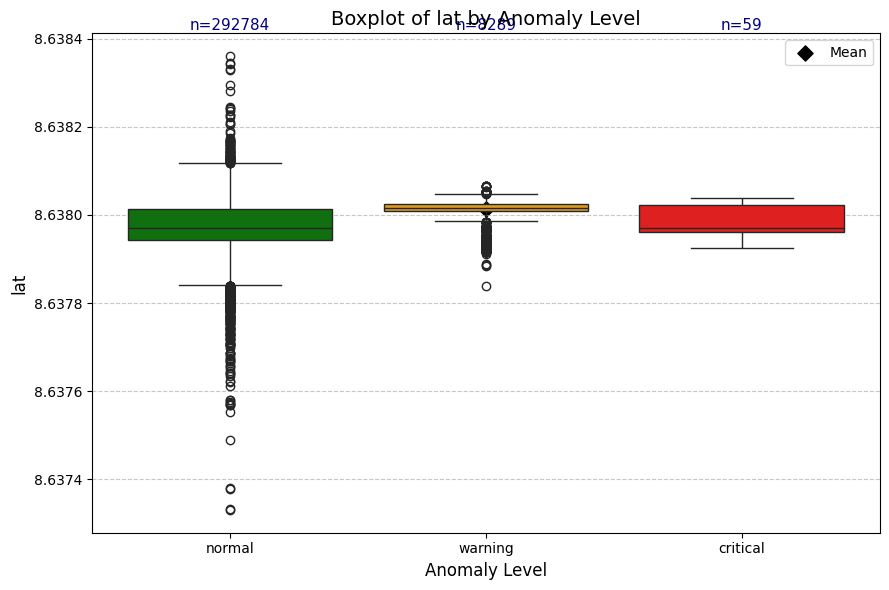

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\1716406144.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


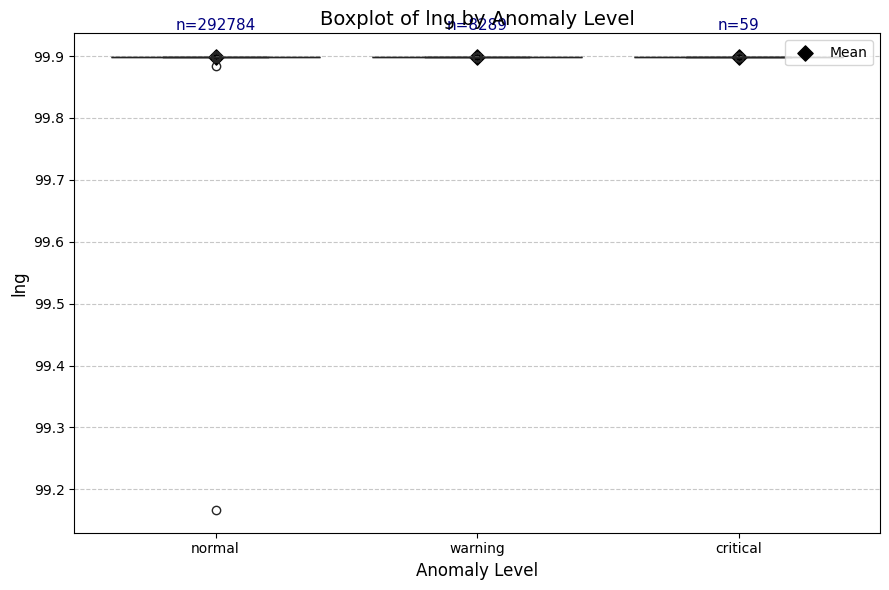


All Box Plots for Original Features (with Mean & Count) successfully created!


In [ ]:
# --- 4. Box Plot of Original Features by Anomaly Level ---
print("\n--- Box Plots of Original Features by Anomaly Level ---")
# Optional: define boxprops if you want to customize box appearance
# boxprops = dict(edgecolor='black', linewidth=1.5)

for feature in numerical_cols: # ใช้ numerical_cols เพื่อเข้าถึงคอลัมน์ที่ไม่ถูก scale
    plt.figure(figsize=(9, 6))
    sns.boxplot(
        data=df_analysis,
        x='anomaly_level',
        y=feature,
        order=['normal', 'warning', 'critical'],
        palette=palette_anomaly
    )
    plt.title(f'Boxplot of {feature} by Anomaly Level', fontsize=14)
    plt.xlabel('Anomaly Level', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\nAll Box Plots for Original Features successfully created!")

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\73486435.py:8: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\73486435.py:8: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\73486435.py:8: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\73486435.py:8: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3592 (\N{THAI CHARACTER CHO CHAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv

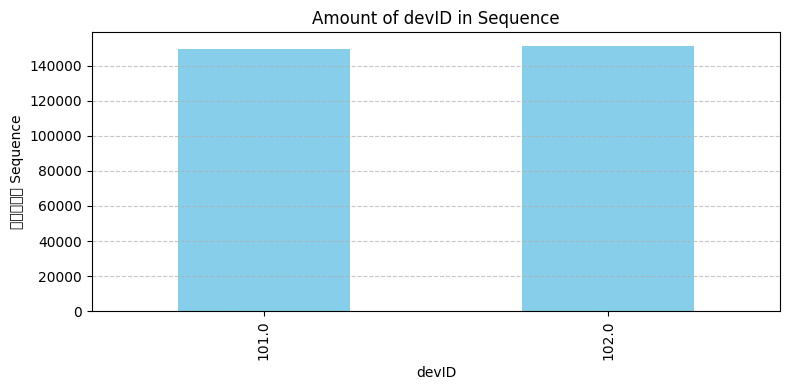

Dynamic 95th percentile (Warning) threshold = 0.00810
Dynamic 99th percentile (Critical) threshold = 0.01337


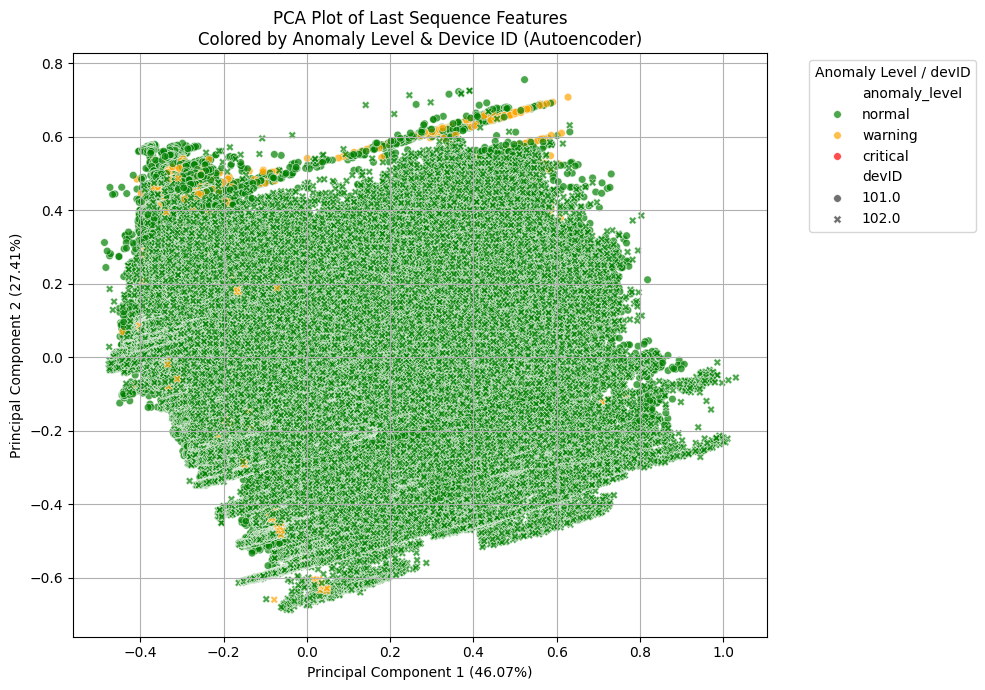


Bar Plot of devID count, dynamic thresholds, and PCA Plot successfully created!


In [ ]:
# --- 5.1. Bar Plot: จำนวนข้อมูลแต่ละ devID ---
plt.figure(figsize=(8, 4))
df_results['devID'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Amount of devID in Sequence')
plt.xlabel('devID')
plt.ylabel('จำนวน Sequence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 5.2. Dynamic Thresholds (Percentile) ---
threshold_warning = np.percentile(df_results['reconstruction_error'], 95)
threshold_critical = np.percentile(df_results['reconstruction_error'], 99)
print(f"Dynamic 95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"Dynamic 99th percentile (Critical) threshold = {threshold_critical:.5f}")

# --- 5.3. PCA Plot of Last Sequence Features by Anomaly Level ---
# X_seq_test มี shape (num_sequences, SEQUENCE_LENGTH, num_features)
# เราจะใช้ค่าจาก timestamp สุดท้าย (index SEQUENCE_LENGTH - 1)
X_features_last_step = X_seq_test[:, -1, :] # นี่คือ features ที่ scaled แล้วของ timestamp สุดท้ายในแต่ละ sequence

pca_autoencoder = PCA(n_components=2)
X_pca_autoencoder = pca_autoencoder.fit_transform(X_features_last_step)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_autoencoder[:, 0], y=X_pca_autoencoder[:, 1],
                hue=df_results['anomaly_level'], style=df_results['devID'],
                palette=palette_anomaly, alpha=0.7, s=30,
                hue_order=['normal', 'warning', 'critical'])
plt.title('PCA Plot of Last Sequence Features\nColored by Anomaly Level & Device ID (Autoencoder)')
plt.xlabel(f'Principal Component 1 ({pca_autoencoder.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca_autoencoder.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Anomaly Level / devID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nBar Plot of devID count, dynamic thresholds, and PCA Plot successfully created!")

# Sumulate in Device

--- Starting Real-time Anomaly Detection Simulation (Last 1000 Rows by Timestamp) ---
Warning Threshold: 0.01000
Critical Threshold: 0.02000
--------------------------------------------------


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:13:20.890000, Error: 0.003617, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:13:32.050000, Error: 0.003539, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:13:42.970000, Error: 0.003351, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:14:27.120000, Error: 0.003364, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:14:38.050000, Error: 0.003135, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:14:49.030000, Error: 0.003258, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:14:59.950000, Error: 0.003258, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:15:11.150000, Error: 0.003226, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:16:05.990000, Error: 0.003111, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:16:16.910000, Error: 0.003591, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:16:27.830000, Error: 0.003275, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:16:38.980000, Error: 0.003493, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:17:22.960000, Error: 0.003536, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:17:44.810000, Error: 0.003563, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:17:56.100000, Error: 0.003315, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:18:39.860000, Error: 0.003021, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:18:50.780000, Error: 0.003028, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:19:02.030000, Error: 0.003005, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:19:39.960000, Error: 0.005300, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:19:56.800000, Error: 0.002996, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 102.0, Time: 2025-06-29 17:20:07.950000, Error: 0.002971, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:20:30.060000, Error: 0.002808, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:20:40.980000, Error: 0.002793, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:20:51.970000, Error: 0.002749, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:21:08.020000, Error: 0.004885, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:21:18.950000, Error: 0.004872, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:21:30.110000, Error: 0.003810, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:21:46.880000, Error: 0.002703, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:21:57.960000, Error: 0.002787, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:22:08.890000, Error: 0.002326, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:22:19.810000, Error: 0.002578, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:22:31.030000, Error: 0.002646, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:22:57.920000, Error: 0.003715, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:23:15.050000, Error: 0.002726, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:23:25.970000, Error: 0.002791, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:23:36.890000, Error: 0.002741, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:23:47.800000, Error: 0.002701, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:24:03.930000, Error: 0.003740, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:24:14.850000, Error: 0.003761, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:24:31.960000, Error: 0.002660, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:24:53.920000, Error: 0.002648, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:25:04.850000, Error: 0.002664, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:25:15.770000, Error: 0.002718, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:25:26.980000, Error: 0.002758, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:25:37.900000, Error: 0.002745, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:25:48.830000, Error: 0.002573, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:26:04.930000, Error: 0.003656, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:26:15.850000, Error: 0.003623, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:26:26.990000, Error: 0.003408, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:26:43.820000, Error: 0.002071, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:26:55.040000, Error: 0.002102, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:27:05.960000, Error: 0.002038, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:27:16.880000, Error: 0.002445, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:27:27.810000, Error: 0.002335, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:27:38.980000, Error: 0.002237, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:27:54.970000, Error: 0.003414, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:28:05.960000, Error: 0.003429, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:28:16.880000, Error: 0.003199, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:28:28.050000, Error: 0.002855, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:28:45.190000, Error: 0.002402, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:28:56.220000, Error: 0.002329, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:29:07.250000, Error: 0.002896, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:29:18.290000, Error: 0.002892, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:29:30.020000, Error: 0.002980, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:29:40.950000, Error: 0.003925, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:29:55.840000, Error: 0.003038, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:30:07.060000, Error: 0.002855, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:30:17.980000, Error: 0.002758, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:30:36.230000, Error: 0.003734, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:30:58.290000, Error: 0.003982, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:31:10.030000, Error: 0.003755, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:31:20.950000, Error: 0.003336, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:31:45.930000, Error: 0.002941, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:32:04.990000, Error: 0.003281, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:32:16.150000, Error: 0.002857, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:32:30.820000, Error: 0.002570, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:32:42.140000, Error: 0.002661, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:33:01.840000, Error: 0.003385, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:33:12.760000, Error: 0.003440, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:33:24.050000, Error: 0.003468, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:33:34.970000, Error: 0.003467, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:33:49.070000, Error: 0.002772, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:34:07.870000, Error: 0.003465, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:34:19.030000, Error: 0.003499, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:34:29.950000, Error: 0.003455, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:34:43.990000, Error: 0.002478, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:34:52.230000, Error: 0.003359, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:35:07.030000, Error: 0.002609, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:35:17.950000, Error: 0.002497, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:35:36.970000, Error: 0.003316, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:35:47.900000, Error: 0.003343, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:35:59.130000, Error: 0.003975, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:36:12.860000, Error: 0.002260, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:36:24.080000, Error: 0.001889, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:36:36.210000, Error: 0.001939, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:36:54.030000, Error: 0.004275, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:37:05.080000, Error: 0.004210, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:37:27.060000, Error: 0.004401, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:37:43.130000, Error: 0.001804, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:37:54.050000, Error: 0.001656, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:38:05.180000, Error: 0.001415, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:38:16.990000, Error: 0.001470, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:38:32.860000, Error: 0.004312, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:38:44.020000, Error: 0.004090, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:38:54.940000, Error: 0.003776, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:39:06.080000, Error: 0.003771, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:39:35.040000, Error: 0.001516, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:39:45.960000, Error: 0.002031, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:39:57.020000, Error: 0.001890, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:40:07.940000, Error: 0.002090, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:40:22.990000, Error: 0.003602, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:40:33.910000, Error: 0.002644, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:40:44.830000, Error: 0.002788, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:41:07.060000, Error: 0.002747, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:41:17.980000, Error: 0.002312, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:41:37.220000, Error: 0.002209, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:41:48.250000, Error: 0.002378, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:41:59.290000, Error: 0.002405, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:42:10.930000, Error: 0.002410, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:42:21.860000, Error: 0.002424, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:42:32.970000, Error: 0.002246, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:42:43.890000, Error: 0.002656, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:42:56.880000, Error: 0.002404, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:43:07.800000, Error: 0.001925, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:43:28.990000, Error: 0.002796, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:43:39.910000, Error: 0.002750, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:43:50.830000, Error: 0.002812, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:44:01.980000, Error: 0.002830, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:44:12.900000, Error: 0.002415, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:44:23.820000, Error: 0.002951, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:44:35.010000, Error: 0.002715, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:44:45.940000, Error: 0.002730, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:44:56.860000, Error: 0.002764, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:45:07.780000, Error: 0.003191, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:45:31.060000, Error: 0.002309, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:45:52.900000, Error: 0.002395, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:46:03.890000, Error: 0.003313, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:46:14.810000, Error: 0.003702, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:46:36.920000, Error: 0.003686, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:46:47.840000, Error: 0.003666, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:47:00.050000, Error: 0.003796, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:47:10.970000, Error: 0.003886, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:47:32.920000, Error: 0.003830, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:47:43.840000, Error: 0.003762, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:47:54.770000, Error: 0.003705, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:48:06.980000, Error: 0.002676, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:48:17.900000, Error: 0.002914, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:48:28.820000, Error: 0.002834, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:48:39.750000, Error: 0.002609, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:48:51.010000, Error: 0.002594, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:49:01.930000, Error: 0.002606, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:49:12.850000, Error: 0.002568, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:49:24.980000, Error: 0.002540, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:49:35.900000, Error: 0.002581, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:49:46.820000, Error: 0.002652, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:49:57.900000, Error: 0.002727, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:50:08.830000, Error: 0.002713, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:50:20.070000, Error: 0.002468, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:50:30.990000, Error: 0.001875, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:50:41.910000, Error: 0.002506, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:50:54.040000, Error: 0.001985, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:51:04.970000, Error: 0.002321, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:51:15.880000, Error: 0.002482, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:51:30.020000, Error: 0.003815, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:51:40.940000, Error: 0.003608, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:51:53.080000, Error: 0.003951, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:52:01.270000, Error: 0.002487, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:52:14.920000, Error: 0.004220, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:52:26.010000, Error: 0.004100, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:52:36.930000, Error: 0.003969, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:52:47.060000, Error: 0.002420, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:52:57.980000, Error: 0.002402, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:53:08.900000, Error: 0.004665, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:53:19.810000, Error: 0.005093, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:53:31.060000, Error: 0.005208, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:53:41.980000, Error: 0.005335, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:53:54.100000, Error: 0.005443, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:54:05.030000, Error: 0.005349, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:54:16.050000, Error: 0.004947, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:54:26.970000, Error: 0.005014, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:54:39.090000, Error: 0.004485, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:54:50.020000, Error: 0.004888, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:55:00.940000, Error: 0.004806, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:55:11.860000, Error: 0.005148, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:55:23.060000, Error: 0.005331, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:55:33.980000, Error: 0.005389, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:55:44.910000, Error: 0.005318, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:55:57.030000, Error: 0.005190, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:56:07.950000, Error: 0.005109, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:56:18.880000, Error: 0.005076, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:56:30.050000, Error: 0.005135, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:56:40.980000, Error: 0.005235, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:56:53.100000, Error: 0.005171, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:57:04.020000, Error: 0.004956, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:57:14.950000, Error: 0.004394, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:57:25.870000, Error: 0.004363, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:57:37.050000, Error: 0.004009, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:57:49.170000, Error: 0.004461, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:58:00.090000, Error: 0.004820, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:58:11.020000, Error: 0.004921, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:58:21.940000, Error: 0.004527, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:58:28.080000, Error: 0.004017, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 17:58:44.010000, Error: 0.003858, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 17:58:56.130000, Error: 0.002318, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:59:14.020000, Error: 0.004057, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:59:24.940000, Error: 0.004003, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:59:35.910000, Error: 0.004146, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 17:59:46.830000, Error: 0.003757, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 17:59:58.960000, Error: 0.003734, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:00:09.880000, Error: 0.003563, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:00:14.910000, Error: 0.002287, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:00:25.830000, Error: 0.002280, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:00:37.020000, Error: 0.002373, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:00:47.950000, Error: 0.002381, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:01:00.070000, Error: 0.002365, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:01:16.940000, Error: 0.003611, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:01:27.860000, Error: 0.003653, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:01:39.990000, Error: 0.003864, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:01:50.900000, Error: 0.003889, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:02:01.960000, Error: 0.003510, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-pa

  DevID: 101.0, Time: 2025-06-29 18:02:12.880000, Error: 0.003545, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:02:23.800000, Error: 0.003400, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:02:34.990000, Error: 0.003234, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:02:41.100000, Error: 0.002329, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:02:52.020000, Error: 0.002269, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:03:02.950000, Error: 0.001931, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:03:13.860000, Error: 0.001821, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:03:25.020000, Error: 0.002228, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:03:35.940000, Error: 0.002148, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:03:46.870000, Error: 0.002087, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:03:54.050000, Error: 0.002825, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:04:04.970000, Error: 0.002743, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:04:16.040000, Error: 0.002786, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:04:26.960000, Error: 0.002721, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:04:39.090000, Error: 0.002995, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:04:50.050000, Error: 0.003055, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:05:00.970000, Error: 0.002875, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:05:11.900000, Error: 0.002801, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:05:22.820000, Error: 0.002664, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:05:34.940000, Error: 0.002075, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:05:45.860000, Error: 0.002094, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:05:49.900000, Error: 0.002436, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:06:01.060000, Error: 0.002579, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:06:11.980000, Error: 0.002549, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:06:22.900000, Error: 0.002458, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:06:35.220000, Error: 0.002407, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:06:41.980000, Error: 0.001775, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:06:57.230000, Error: 0.002390, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:07:08.290000, Error: 0.002359, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:07:19.340000, Error: 0.002312, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:07:36.990000, Error: 0.001741, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:07:49.110000, Error: 0.001708, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:08:00.250000, Error: 0.001805, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:08:11.230000, Error: 0.001833, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:08:26.920000, Error: 0.002446, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:08:37.830000, Error: 0.002682, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:08:49.110000, Error: 0.002587, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:09:00.030000, Error: 0.002465, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:09:11.110000, Error: 0.001900, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:09:29.820000, Error: 0.002051, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:09:34.150000, Error: 0.001739, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:09:52.040000, Error: 0.002054, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:10:03.040000, Error: 0.002087, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:10:14.130000, Error: 0.002017, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:10:27.080000, Error: 0.002117, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:10:48.920000, Error: 0.002028, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:10:59.840000, Error: 0.002020, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:11:10.750000, Error: 0.001962, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:11:23.040000, Error: 0.001638, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:11:33.960000, Error: 0.001833, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:11:44.880000, Error: 0.001988, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:11:55.800000, Error: 0.002080, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:12:07.150000, Error: 0.001962, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:12:20.910000, Error: 0.001852, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:12:39.920000, Error: 0.001848, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:12:50.840000, Error: 0.001727, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:13:03.140000, Error: 0.001808, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:13:14.120000, Error: 0.001898, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:13:25.090000, Error: 0.001744, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:13:36.160000, Error: 0.001606, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:13:47.240000, Error: 0.001499, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:13:59.980000, Error: 0.001784, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:14:10.910000, Error: 0.001916, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:14:21.830000, Error: 0.001888, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:14:33.020000, Error: 0.001912, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:14:43.940000, Error: 0.001821, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:14:56.060000, Error: 0.001801, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:15:07.030000, Error: 0.001842, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:15:17.950000, Error: 0.001767, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:15:28.870000, Error: 0.001599, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:15:39.790000, Error: 0.001566, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:15:50.710000, Error: 0.001531, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:16:03.090000, Error: 0.001611, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:16:14.010000, Error: 0.001644, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:16:24.940000, Error: 0.001415, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:16:35.860000, Error: 0.001588, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:16:48.040000, Error: 0.001487, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:16:58.960000, Error: 0.001675, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:17:09.890000, Error: 0.001914, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:17:20.810000, Error: 0.001847, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:17:31.730000, Error: 0.001658, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:17:43.110000, Error: 0.001637, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:17:54.030000, Error: 0.001955, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:18:06.150000, Error: 0.001938, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:18:28.270000, Error: 0.001996, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:18:39.240000, Error: 0.002314, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:18:50.890000, Error: 0.002338, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:19:03.020000, Error: 0.002240, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:19:15.810000, Error: 0.001961, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:19:27.100000, Error: 0.001942, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:19:36.040000, Error: 0.002325, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:19:38.030000, Error: 0.001968, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:20:08.950000, Error: 0.002304, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:20:11.050000, Error: 0.001808, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:20:32.120000, Error: 0.002371, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:20:43.200000, Error: 0.002378, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:20:54.280000, Error: 0.002309, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:21:06.920000, Error: 0.002306, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:21:17.840000, Error: 0.002363, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:21:28.760000, Error: 0.002316, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:21:40.050000, Error: 0.002294, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:21:52.170000, Error: 0.002334, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:22:03.160000, Error: 0.002453, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:22:14.250000, Error: 0.002400, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:22:25.330000, Error: 0.002316, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:22:37.840000, Error: 0.001704, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:22:48.890000, Error: 0.002840, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:22:59.810000, Error: 0.003201, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:23:11.070000, Error: 0.003185, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:23:23.190000, Error: 0.003090, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:23:34.180000, Error: 0.003144, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:23:46.040000, Error: 0.002109, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:23:56.960000, Error: 0.002106, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:24:08.100000, Error: 0.002223, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:24:19.960000, Error: 0.003289, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:24:30.880000, Error: 0.002886, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:24:42.010000, Error: 0.003225, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:24:54.130000, Error: 0.003309, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:25:05.120000, Error: 0.003374, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:25:16.200000, Error: 0.003191, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:25:27.900000, Error: 0.002292, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:25:39.130000, Error: 0.002323, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:25:50.950000, Error: 0.003084, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:26:01.870000, Error: 0.003077, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:26:13.950000, Error: 0.002312, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:26:25.060000, Error: 0.003052, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:26:35.990000, Error: 0.002873, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:26:46.900000, Error: 0.002733, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:26:59.030000, Error: 0.002993, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:27:09.960000, Error: 0.003280, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:27:31.920000, Error: 0.003357, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:27:44.040000, Error: 0.003371, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:27:54.960000, Error: 0.003415, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:28:05.890000, Error: 0.003521, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:28:08.030000, Error: 0.001937, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:28:18.950000, Error: 0.001967, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:28:29.880000, Error: 0.002290, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:28:40.010000, Error: 0.003560, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:28:50.930000, Error: 0.003777, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:29:01.850000, Error: 0.003871, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:29:15.020000, Error: 0.002148, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:29:25.940000, Error: 0.002595, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:29:38.080000, Error: 0.002832, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:30:10.850000, Error: 0.002900, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:30:20.850000, Error: 0.003801, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:30:34.070000, Error: 0.003161, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:31:05.960000, Error: 0.003847, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:31:16.880000, Error: 0.004023, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:31:29.010000, Error: 0.003987, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:31:40.050000, Error: 0.004204, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:31:50.970000, Error: 0.003031, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:32:01.900000, Error: 0.003005, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:32:14.020000, Error: 0.003093, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:32:25.130000, Error: 0.003188, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:32:36.050000, Error: 0.003100, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:32:46.980000, Error: 0.003007, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:32:59.100000, Error: 0.002901, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:33:10.020000, Error: 0.003346, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:33:21.100000, Error: 0.003360, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:33:32.020000, Error: 0.003271, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:33:42.940000, Error: 0.005153, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:33:55.080000, Error: 0.005374, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:34:16.920000, Error: 0.005400, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:34:32.030000, Error: 0.003215, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:34:43.010000, Error: 0.003235, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:34:53.930000, Error: 0.003233, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:35:04.860000, Error: 0.003104, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:35:17.050000, Error: 0.002759, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:35:27.970000, Error: 0.002813, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:35:39.040000, Error: 0.002863, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:35:49.960000, Error: 0.002866, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:35:57.890000, Error: 0.005743, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:36:08.810000, Error: 0.005694, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:36:19.740000, Error: 0.007053, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:36:35.040000, Error: 0.003348, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:36:47.170000, Error: 0.003213, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:36:58.100000, Error: 0.003205, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:37:09.030000, Error: 0.003634, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:37:19.950000, Error: 0.003733, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:37:31.050000, Error: 0.003636, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:37:54.100000, Error: 0.003655, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:38:05.020000, Error: 0.003359, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:38:15.950000, Error: 0.003449, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:38:28.080000, Error: 0.003387, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:38:39.010000, Error: 0.003160, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:38:50.050000, Error: 0.003235, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:39:00.980000, Error: 0.003392, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:39:11.900000, Error: 0.003491, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:39:24.030000, Error: 0.003329, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:39:35.020000, Error: 0.003069, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:39:45.940000, Error: 0.003314, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:39:55.120000, Error: 0.006541, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:40:09.040000, Error: 0.002731, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:40:19.960000, Error: 0.002841, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:40:30.890000, Error: 0.002751, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:40:43.060000, Error: 0.002694, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:40:53.980000, Error: 0.002502, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:41:05.050000, Error: 0.002816, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:41:15.970000, Error: 0.002763, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:41:28.090000, Error: 0.002655, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:41:50.560000, Error: 0.002499, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:42:02.690000, Error: 0.002419, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:42:14.050000, Error: 0.002756, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:42:24.970000, Error: 0.002807, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:42:37.090000, Error: 0.001959, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:43:07.040000, Error: 0.006675, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:43:17.970000, Error: 0.007062, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:43:22.280000, Error: 0.002210, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:43:33.320000, Error: 0.002082, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:43:45.070000, Error: 0.001788, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:43:57.190000, Error: 0.001778, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:44:08.120000, Error: 0.001836, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:44:19.040000, Error: 0.001826, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:44:37.020000, Error: 0.007261, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:44:47.950000, Error: 0.006805, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:44:58.870000, Error: 0.006726, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:45:11.070000, Error: 0.006698, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:45:21.990000, Error: 0.006399, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:45:32.920000, Error: 0.006217, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:45:45.040000, Error: 0.006419, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:45:56.030000, Error: 0.006401, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:46:06.950000, Error: 0.006440, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:46:19.070000, Error: 0.006404, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:46:40.920000, Error: 0.006372, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:46:53.040000, Error: 0.006412, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:47:03.960000, Error: 0.006473, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:47:14.880000, Error: 0.006611, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:47:27.010000, Error: 0.006312, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:47:33.160000, Error: 0.001791, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:47:44.080000, Error: 0.001694, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:48:07.130000, Error: 0.001596, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:48:18.050000, Error: 0.001565, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:48:35.070000, Error: 0.006607, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:48:45.990000, Error: 0.006650, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:48:56.920000, Error: 0.006101, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:49:09.040000, Error: 0.005747, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:49:15.180000, Error: 0.001555, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:49:26.270000, Error: 0.001601, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:49:39.090000, Error: 0.001643, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:49:50.020000, Error: 0.001644, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:50:13.210000, Error: 0.001643, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:50:24.130000, Error: 0.001538, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:50:36.250000, Error: 0.001427, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:50:47.220000, Error: 0.001543, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:50:58.270000, Error: 0.001900, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:51:11.090000, Error: 0.001973, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:51:22.020000, Error: 0.001915, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:51:34.270000, Error: 0.001826, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:51:45.310000, Error: 0.001973, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:51:58.040000, Error: 0.001989, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:52:08.960000, Error: 0.002651, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:52:20.980000, Error: 0.005569, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:52:33.050000, Error: 0.002843, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:52:33.110000, Error: 0.005499, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:52:44.010000, Error: 0.003488, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:52:55.030000, Error: 0.003553, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:53:07.150000, Error: 0.003534, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:53:18.190000, Error: 0.003083, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:53:29.300000, Error: 0.002976, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:53:42.070000, Error: 0.002177, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:53:52.990000, Error: 0.002188, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:54:05.110000, Error: 0.002278, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:54:16.030000, Error: 0.002115, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:54:26.960000, Error: 0.001991, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:54:30.140000, Error: 0.002761, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:54:41.060000, Error: 0.002508, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:54:54.070000, Error: 0.002873, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:55:13.250000, Error: 0.001971, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:55:24.280000, Error: 0.001963, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:55:36.070000, Error: 0.001822, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:55:48.190000, Error: 0.001881, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:55:52.050000, Error: 0.003081, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:56:04.170000, Error: 0.003009, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:56:15.090000, Error: 0.003046, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:56:26.020000, Error: 0.002928, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:56:38.140000, Error: 0.002915, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:56:49.070000, Error: 0.003479, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:57:07.960000, Error: 0.001826, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:57:19.060000, Error: 0.001821, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:57:31.180000, Error: 0.001867, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:57:42.110000, Error: 0.001908, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:57:53.030000, Error: 0.001840, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:58:05.150000, Error: 0.001957, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:58:16.210000, Error: 0.001862, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:58:22.040000, Error: 0.003905, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:58:32.960000, Error: 0.003837, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:58:44.050000, Error: 0.004336, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 18:58:56.180000, Error: 0.004328, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:59:07.100000, Error: 0.004537, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:59:19.220000, Error: 0.004539, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 18:59:30.200000, Error: 0.004458, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 18:59:37.230000, Error: 0.001686, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 18:59:48.150000, Error: 0.001781, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:00:04.990000, Error: 0.004349, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:00:11.190000, Error: 0.001665, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:00:22.120000, Error: 0.001753, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:00:33.040000, Error: 0.001988, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:00:45.180000, Error: 0.002065, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:00:56.100000, Error: 0.002006, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:01:08.310000, Error: 0.002033, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:01:19.950000, Error: 0.001979, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:01:32.070000, Error: 0.001998, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:01:42.990000, Error: 0.001967, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:01:54.020000, Error: 0.001920, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:02:06.140000, Error: 0.002160, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:02:17.070000, Error: 0.002196, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:02:25.220000, Error: 0.004287, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:02:37.060000, Error: 0.004245, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:02:49.180000, Error: 0.004510, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:03:00.110000, Error: 0.004438, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:03:12.230000, Error: 0.003288, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:03:23.300000, Error: 0.003362, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:03:36.030000, Error: 0.003793, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:03:46.950000, Error: 0.003417, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:03:59.080000, Error: 0.002907, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:04:20.990000, Error: 0.003173, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:04:33.120000, Error: 0.002809, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:04:44.040000, Error: 0.002760, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:04:56.150000, Error: 0.002716, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:05:07.090000, Error: 0.002770, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:05:19.210000, Error: 0.002639, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:05:22.050000, Error: 0.002097, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:05:34.170000, Error: 0.002049, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:05:53.280000, Error: 0.002580, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:06:16.930000, Error: 0.002648, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:06:27.850000, Error: 0.002696, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:06:39.980000, Error: 0.002641, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:06:51.020000, Error: 0.002554, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:06:55.220000, Error: 0.002101, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:07:07.090000, Error: 0.002089, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:07:18.010000, Error: 0.002105, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:07:37.880000, Error: 0.002709, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:07:49.080000, Error: 0.002633, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:08:01.200000, Error: 0.002472, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:08:12.190000, Error: 0.002386, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:08:25.060000, Error: 0.002219, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:08:28.110000, Error: 0.002689, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:08:48.110000, Error: 0.002045, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:08:59.030000, Error: 0.002185, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:09:10.160000, Error: 0.002153, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:09:22.280000, Error: 0.002084, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:09:36.970000, Error: 0.002738, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:09:46.050000, Error: 0.002074, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:10:00.030000, Error: 0.002877, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:10:10.960000, Error: 0.003972, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:10:23.080000, Error: 0.004023, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:10:46.120000, Error: 0.004146, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:10:57.050000, Error: 0.004401, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:11:18.240000, Error: 0.002106, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:11:20.090000, Error: 0.004421, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:11:41.950000, Error: 0.001857, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:11:43.140000, Error: 0.004404, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:12:05.240000, Error: 0.001683, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:12:06.180000, Error: 0.004324, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:12:17.120000, Error: 0.004318, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:12:29.110000, Error: 0.001761, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:12:40.160000, Error: 0.004359, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:12:51.160000, Error: 0.004237, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:13:03.940000, Error: 0.004138, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:13:14.860000, Error: 0.003902, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:13:26.990000, Error: 0.003952, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:13:37.910000, Error: 0.003739, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:13:50.130000, Error: 0.003843, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:14:01.140000, Error: 0.003931, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:14:12.150000, Error: 0.003857, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:14:25.050000, Error: 0.003763, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:14:35.970000, Error: 0.003678, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:14:48.090000, Error: 0.003701, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:14:49.070000, Error: 0.001827, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:14:59.060000, Error: 0.003688, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:15:12.250000, Error: 0.001770, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:15:23.310000, Error: 0.002054, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:15:34.230000, Error: 0.003784, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:15:45.150000, Error: 0.003592, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:15:57.270000, Error: 0.003492, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:16:21.020000, Error: 0.003452, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:16:23.020000, Error: 0.002047, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:16:33.940000, Error: 0.002251, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:16:46.070000, Error: 0.002251, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:16:56.990000, Error: 0.002632, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:17:08.070000, Error: 0.003531, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:17:18.990000, Error: 0.003178, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:17:31.110000, Error: 0.002919, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:17:42.030000, Error: 0.002551, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:17:54.150000, Error: 0.002715, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:18:05.080000, Error: 0.001966, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:18:17.200000, Error: 0.001925, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:18:28.260000, Error: 0.001976, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:18:30.020000, Error: 0.002793, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:18:42.140000, Error: 0.002914, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:18:53.060000, Error: 0.002948, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:19:27.220000, Error: 0.001928, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:19:38.230000, Error: 0.001897, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:19:40.200000, Error: 0.003091, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:19:53.040000, Error: 0.003033, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:20:14.980000, Error: 0.001916, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:20:25.900000, Error: 0.001926, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:20:38.030000, Error: 0.001972, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:20:50.280000, Error: 0.003591, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:21:01.160000, Error: 0.001939, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:21:13.940000, Error: 0.003978, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:21:26.060000, Error: 0.004032, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:21:37.080000, Error: 0.003879, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:21:49.200000, Error: 0.003236, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:22:01.060000, Error: 0.003290, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:22:13.180000, Error: 0.003331, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:22:24.110000, Error: 0.003351, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:22:36.220000, Error: 0.003252, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:22:47.240000, Error: 0.003487, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:22:59.980000, Error: 0.003422, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:23:08.830000, Error: 0.001878, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:23:20.960000, Error: 0.001793, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:23:34.130000, Error: 0.004118, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:23:44.170000, Error: 0.001826, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:23:58.010000, Error: 0.004688, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:24:10.130000, Error: 0.005405, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:24:21.060000, Error: 0.005534, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:24:33.240000, Error: 0.005406, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:24:45.090000, Error: 0.006008, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:24:54.010000, Error: 0.001911, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:25:08.990000, Error: 0.005887, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:25:17.060000, Error: 0.002090, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:25:32.040000, Error: 0.006092, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:25:40.110000, Error: 0.002076, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:25:51.030000, Error: 0.002168, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:26:03.150000, Error: 0.002142, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:26:14.060000, Error: 0.002105, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:26:26.190000, Error: 0.001824, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:26:37.110000, Error: 0.001854, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:26:49.220000, Error: 0.001768, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:27:00.260000, Error: 0.001882, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:27:13.020000, Error: 0.001923, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:27:23.940000, Error: 0.002228, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:27:36.070000, Error: 0.002289, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:27:46.990000, Error: 0.002337, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:27:59.110000, Error: 0.002453, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:28:10.060000, Error: 0.002181, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:28:22.180000, Error: 0.001984, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:28:33.190000, Error: 0.001891, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:28:45.940000, Error: 0.001898, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:28:56.870000, Error: 0.001920, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:29:09.190000, Error: 0.001846, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:29:20.170000, Error: 0.002161, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:29:32.980000, Error: 0.002247, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:29:39.050000, Error: 0.006020, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:29:56.030000, Error: 0.002443, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:30:02.080000, Error: 0.006027, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:30:13.070000, Error: 0.005713, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:30:36.230000, Error: 0.005744, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:30:49.050000, Error: 0.005416, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:30:59.980000, Error: 0.005530, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:31:12.110000, Error: 0.005196, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:31:23.040000, Error: 0.005001, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:31:35.160000, Error: 0.005230, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:31:46.130000, Error: 0.005298, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:31:58.250000, Error: 0.005127, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:32:10.040000, Error: 0.005260, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:32:22.160000, Error: 0.004875, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:32:33.090000, Error: 0.004753, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:32:45.210000, Error: 0.004764, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:32:56.130000, Error: 0.004417, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:33:08.300000, Error: 0.004122, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:33:19.260000, Error: 0.004217, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:33:32.010000, Error: 0.004354, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:33:42.940000, Error: 0.003777, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:33:49.060000, Error: 0.002456, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:33:59.980000, Error: 0.002496, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:34:12.100000, Error: 0.002857, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:34:23.020000, Error: 0.002948, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:34:35.150000, Error: 0.002993, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:34:46.070000, Error: 0.002968, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:34:58.190000, Error: 0.002860, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:35:16.080000, Error: 0.004125, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:35:28.200000, Error: 0.004169, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:35:40.060000, Error: 0.002819, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:36:03.130000, Error: 0.002764, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:36:15.250000, Error: 0.003247, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:36:26.350000, Error: 0.003226, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:36:39.010000, Error: 0.003836, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:36:49.940000, Error: 0.002868, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:37:02.060000, Error: 0.002909, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:37:12.980000, Error: 0.002958, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:37:25.110000, Error: 0.002800, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:37:36.030000, Error: 0.002703, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:37:48.220000, Error: 0.002627, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:37:59.270000, Error: 0.002468, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:38:12.020000, Error: 0.002478, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:38:22.950000, Error: 0.002512, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:38:35.070000, Error: 0.002867, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:38:46.180000, Error: 0.002660, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:38:59.020000, Error: 0.002597, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:39:09.940000, Error: 0.003126, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:39:22.290000, Error: 0.003324, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:39:33.250000, Error: 0.003326, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:39:46.100000, Error: 0.003216, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:39:57.020000, Error: 0.003160, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:40:00.270000, Error: 0.002902, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:40:11.220000, Error: 0.002851, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:40:23.950000, Error: 0.002861, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:40:44.020000, Error: 0.003129, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:40:56.140000, Error: 0.003003, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:41:07.250000, Error: 0.002668, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:41:30.930000, Error: 0.002936, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:41:34.030000, Error: 0.002866, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:41:44.950000, Error: 0.002866, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:41:57.070000, Error: 0.002871, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:42:08.180000, Error: 0.002999, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:42:21.020000, Error: 0.002848, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:42:31.940000, Error: 0.002850, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:42:53.130000, Error: 0.003014, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:43:04.240000, Error: 0.002447, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:43:17.080000, Error: 0.002694, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:43:40.120000, Error: 0.002699, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:43:51.140000, Error: 0.002617, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:44:03.260000, Error: 0.002862, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:44:15.040000, Error: 0.003191, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:44:27.160000, Error: 0.003126, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:44:38.080000, Error: 0.002908, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:44:50.210000, Error: 0.002890, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:45:01.240000, Error: 0.002838, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:45:14.080000, Error: 0.003022, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:45:37.950000, Error: 0.002878, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:45:48.870000, Error: 0.002804, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:45:50.140000, Error: 0.002804, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:46:01.060000, Error: 0.002393, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:46:13.180000, Error: 0.002471, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:46:24.110000, Error: 0.002449, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:46:36.980000, Error: 0.002399, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:46:47.900000, Error: 0.002515, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:47:00.220000, Error: 0.002678, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:47:11.950000, Error: 0.002691, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:47:23.010000, Error: 0.002770, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:47:46.060000, Error: 0.002831, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:47:58.080000, Error: 0.002736, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:48:10.990000, Error: 0.002827, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:48:21.910000, Error: 0.002723, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:48:33.040000, Error: 0.002890, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:48:44.970000, Error: 0.004031, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:48:57.100000, Error: 0.004473, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:49:08.020000, Error: 0.004684, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:49:19.930000, Error: 0.002409, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:49:32.180000, Error: 0.002457, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:49:44.120000, Error: 0.005033, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:49:55.040000, Error: 0.005287, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:50:18.180000, Error: 0.005032, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:50:30.240000, Error: 0.002512, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:50:41.930000, Error: 0.005039, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:51:04.980000, Error: 0.005064, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:51:17.120000, Error: 0.005695, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:51:28.180000, Error: 0.005871, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:51:40.040000, Error: 0.002186, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:51:52.030000, Error: 0.005933, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:52:03.260000, Error: 0.002217, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:52:04.960000, Error: 0.005826, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:52:15.880000, Error: 0.005776, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:52:26.900000, Error: 0.002175, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:52:39.010000, Error: 0.005784, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:52:51.140000, Error: 0.005742, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:53:02.170000, Error: 0.002187, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:53:14.990000, Error: 0.005618, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:53:25.910000, Error: 0.005612, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:53:38.050000, Error: 0.005445, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:53:59.980000, Error: 0.002260, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:54:01.200000, Error: 0.005803, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:54:12.110000, Error: 0.002424, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:54:23.030000, Error: 0.002477, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:54:35.160000, Error: 0.002642, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:54:58.330000, Error: 0.002537, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:55:22.100000, Error: 0.005752, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:55:34.220000, Error: 0.005754, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:55:45.140000, Error: 0.006005, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:55:45.160000, Error: 0.002357, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:56:08.190000, Error: 0.002476, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:56:21.090000, Error: 0.005949, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:56:32.010000, Error: 0.006285, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:56:44.160000, Error: 0.006238, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:56:55.050000, Error: 0.002511, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:57:06.090000, Error: 0.002420, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:57:18.130000, Error: 0.006027, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:57:29.150000, Error: 0.002263, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:57:41.280000, Error: 0.002238, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:57:52.200000, Error: 0.001508, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:58:04.310000, Error: 0.001621, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:58:16.140000, Error: 0.001689, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:58:28.270000, Error: 0.001780, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:58:39.960000, Error: 0.001842, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 19:58:52.060000, Error: 0.006090, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:59:03.010000, Error: 0.001786, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:59:15.110000, Error: 0.006057, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:59:26.060000, Error: 0.001666, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 19:59:38.180000, Error: 0.001616, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 19:59:49.110000, Error: 0.001900, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 19:59:51.070000, Error: 0.005928, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:00:12.140000, Error: 0.001974, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:00:14.160000, Error: 0.005323, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:00:35.180000, Error: 0.002017, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:00:38.080000, Error: 0.003687, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:01:11.010000, Error: 0.002356, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:01:21.930000, Error: 0.002378, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:01:34.250000, Error: 0.003021, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:01:45.340000, Error: 0.003105, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:02:08.920000, Error: 0.003284, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:02:21.050000, Error: 0.003241, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:02:31.970000, Error: 0.003417, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:02:44.100000, Error: 0.003367, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:02:55.020000, Error: 0.003193, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:03:07.140000, Error: 0.003286, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:03:18.070000, Error: 0.003261, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:03:30.190000, Error: 0.003092, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:03:41.260000, Error: 0.003003, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:03:54.020000, Error: 0.003202, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:04:04.950000, Error: 0.003011, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:04:06.170000, Error: 0.003687, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:04:17.090000, Error: 0.003594, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:04:28.330000, Error: 0.003274, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:04:40.150000, Error: 0.003300, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:04:53.060000, Error: 0.003294, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:05:15.200000, Error: 0.003388, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:05:27.020000, Error: 0.003346, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:05:39.010000, Error: 0.003288, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:05:50.070000, Error: 0.003509, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:06:02.180000, Error: 0.002771, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:06:13.110000, Error: 0.002830, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:06:25.110000, Error: 0.003205, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:06:36.160000, Error: 0.002727, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:06:48.150000, Error: 0.003183, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:06:59.240000, Error: 0.002700, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:07:11.220000, Error: 0.003048, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:07:22.940000, Error: 0.002895, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:07:35.210000, Error: 0.002970, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:07:46.220000, Error: 0.003269, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:07:58.090000, Error: 0.003460, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:08:09.920000, Error: 0.003319, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:08:22.040000, Error: 0.003402, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:08:32.960000, Error: 0.003560, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:08:45.080000, Error: 0.003269, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:08:56.010000, Error: 0.004476, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:09:08.130000, Error: 0.005330, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:09:19.050000, Error: 0.005230, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:09:31.040000, Error: 0.003570, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:09:42.180000, Error: 0.005121, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:09:54.080000, Error: 0.003468, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:10:05.880000, Error: 0.005078, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:10:17.120000, Error: 0.003670, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:10:28.930000, Error: 0.004863, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:10:40.910000, Error: 0.003821, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:11:03.990000, Error: 0.003665, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:11:15.060000, Error: 0.004984, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:11:27.930000, Error: 0.004888, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:11:38.850000, Error: 0.004904, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:11:50.270000, Error: 0.003782, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:12:02.070000, Error: 0.005361, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:12:14.190000, Error: 0.005451, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:12:25.130000, Error: 0.007363, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:12:37.130000, Error: 0.003730, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:12:48.900000, Error: 0.007427, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:13:00.180000, Error: 0.003438, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:13:11.960000, Error: 0.007757, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:13:23.230000, Error: 0.003531, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:13:35.170000, Error: 0.007712, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:13:46.910000, Error: 0.002921, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:13:58.950000, Error: 0.007766, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:14:10.240000, Error: 0.002951, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:14:22.190000, Error: 0.007745, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:14:33.940000, Error: 0.003226, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:14:45.960000, Error: 0.007757, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:14:56.980000, Error: 0.003433, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:15:21.210000, Error: 0.007781, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:15:32.150000, Error: 0.003377, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:15:45.020000, Error: 0.007783, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:15:55.940000, Error: 0.007856, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:16:08.210000, Error: 0.007869, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:16:19.940000, Error: 0.007711, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:16:32.070000, Error: 0.007657, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:16:42.140000, Error: 0.003374, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:16:53.070000, Error: 0.003210, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:17:16.110000, Error: 0.002952, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:17:28.240000, Error: 0.002957, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:17:39.310000, Error: 0.003176, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:17:52.080000, Error: 0.003049, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:18:03.010000, Error: 0.002990, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:18:15.130000, Error: 0.003345, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:18:26.040000, Error: 0.003212, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:18:38.230000, Error: 0.003522, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:18:49.230000, Error: 0.003549, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:19:02.140000, Error: 0.003499, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:19:13.060000, Error: 0.003809, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:19:25.190000, Error: 0.004300, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:19:36.290000, Error: 0.004071, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:19:38.980000, Error: 0.007580, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:19:59.990000, Error: 0.003835, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:20:12.120000, Error: 0.004022, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:20:23.040000, Error: 0.003950, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:20:35.310000, Error: 0.003962, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:20:37.060000, Error: 0.007123, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:20:49.190000, Error: 0.007205, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:20:59.100000, Error: 0.003888, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:21:10.250000, Error: 0.004051, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 101.0, Time: 2025-06-29 20:21:12.230000, Error: 0.007016, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:21:33.950000, Error: 0.003655, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:21:57.100000, Error: 0.003720, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:22:09.230000, Error: 0.003496, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:22:20.150000, Error: 0.003669, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:22:32.270000, Error: 0.003484, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:22:43.180000, Error: 0.003425, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:22:55.310000, Error: 0.003080, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:23:06.320000, Error: 0.002819, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:23:19.100000, Error: 0.002935, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:23:30.020000, Error: 0.003081, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:23:42.150000, Error: 0.003752, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:23:53.060000, Error: 0.003643, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:24:05.230000, Error: 0.003688, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:24:16.220000, Error: 0.003803, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:24:28.090000, Error: 0.003762, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:24:40.220000, Error: 0.004063, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:24:51.870000, Error: 0.003929, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:25:14.920000, Error: 0.003842, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:25:27.980000, Error: 0.006900, Level: NORMAL


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


  DevID: 102.0, Time: 2025-06-29 20:25:48.980000, Error: 0.003852, Level: NORMAL
  DevID: 102.0, Time: 2025-06-29 20:26:01.100000, Error: 0.003926, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:26:02.150000, Error: 0.006640, Level: NORMAL
  DevID: 101.0, Time: 2025-06-29 20:26:13.090000, Error: 0.005133, Level: NORMAL

--- Real-time Anomaly Detection Simulation Complete ---

--- Summary of Real-time Anomaly Detection Results ---
anomaly_level
normal    942
Name: count, dtype: int64


d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\Coding\Python\Project\Landslide\models\LSTM_Autoencoders\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


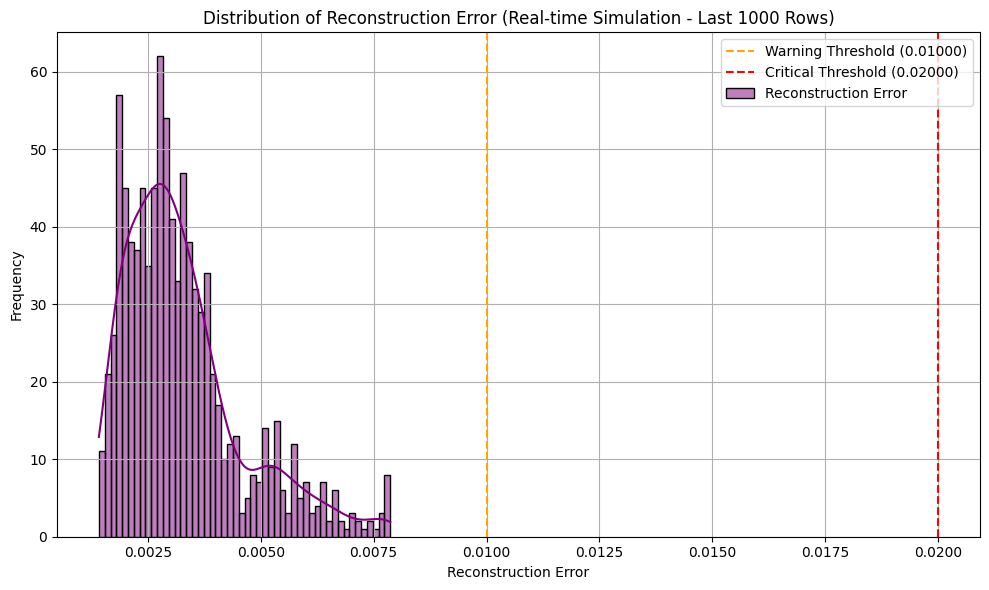

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_realtime_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)


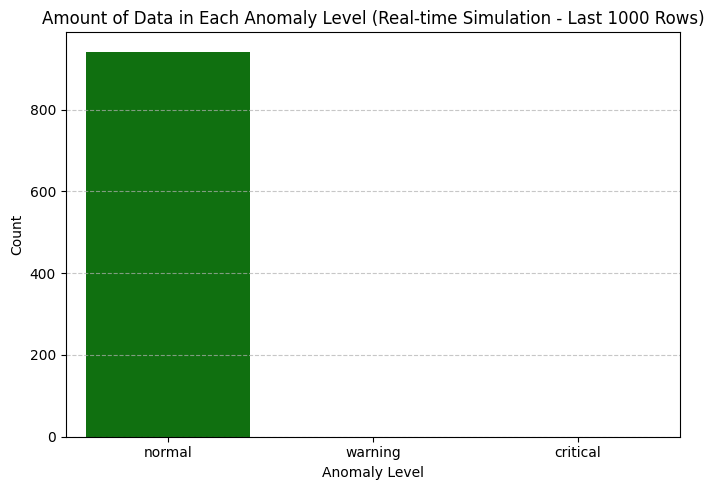

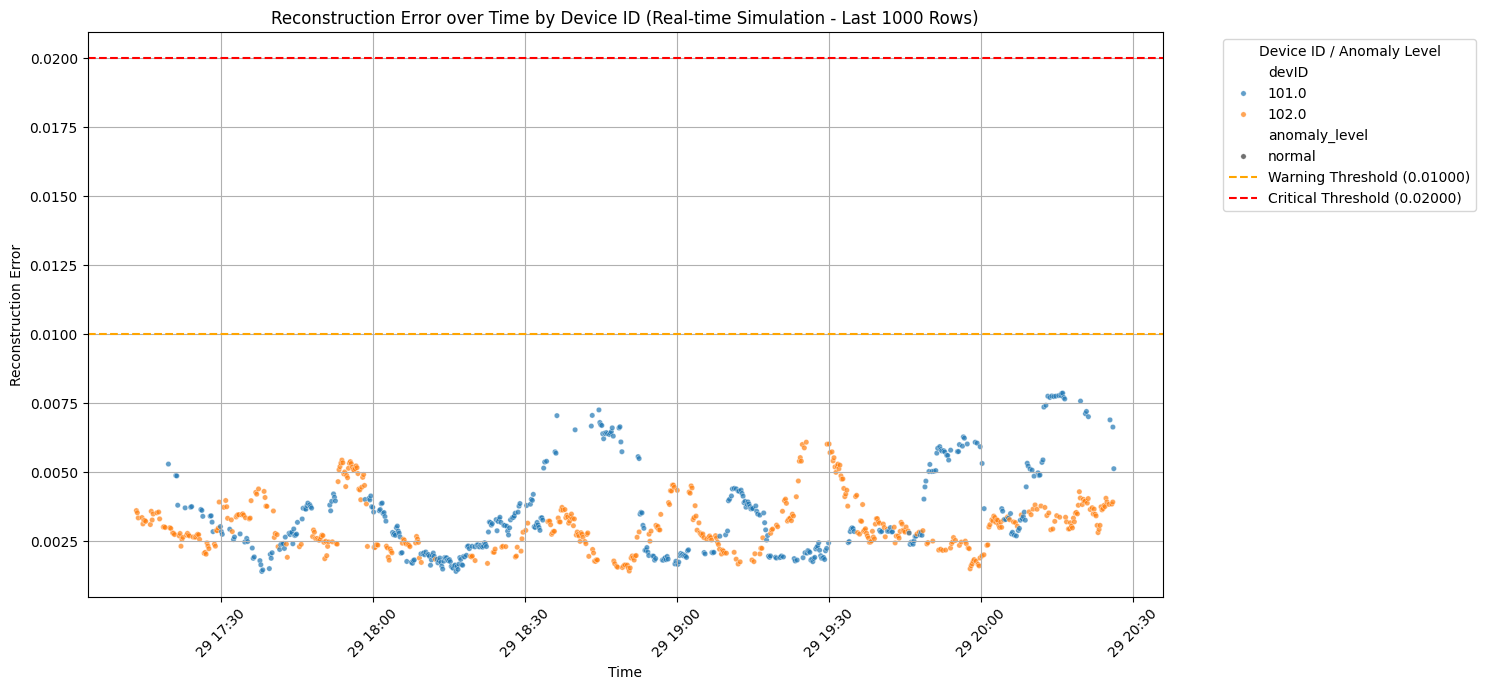


--- Box Plots of Original Features by Anomaly Level (Real-time Simulation - Last 1000 Rows) ---


C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


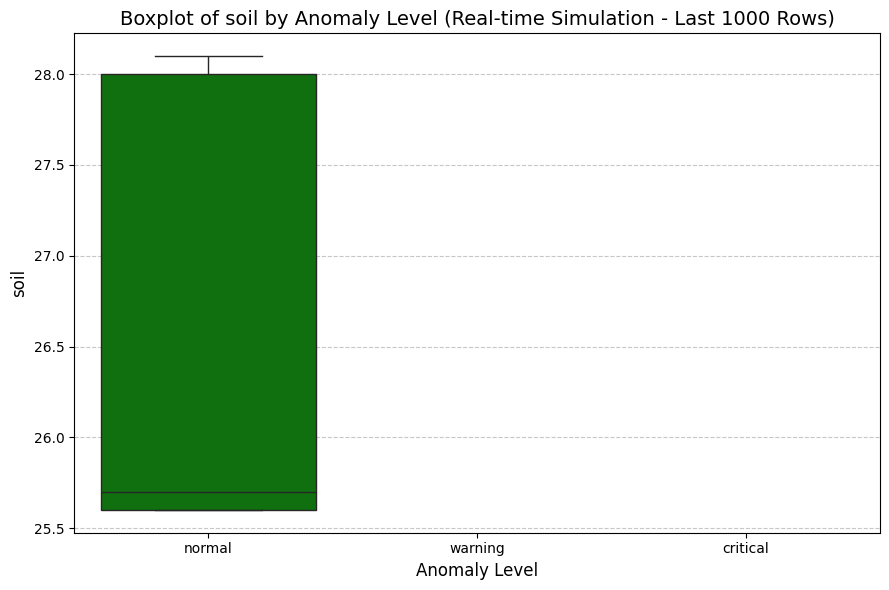

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


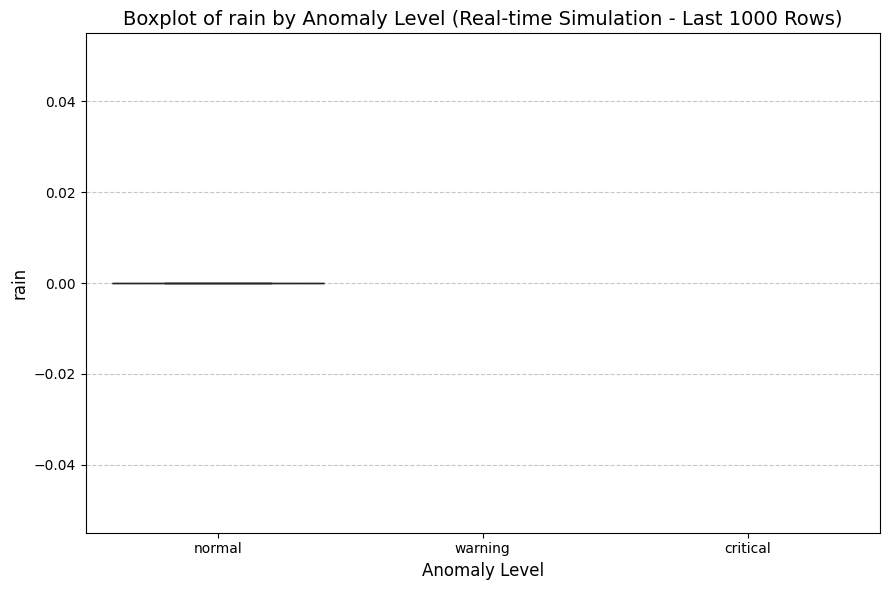

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


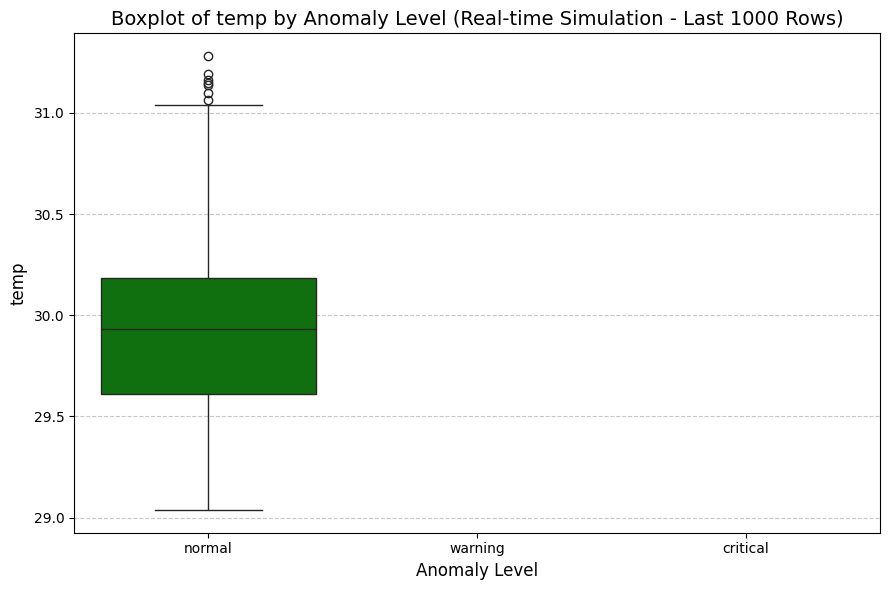

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


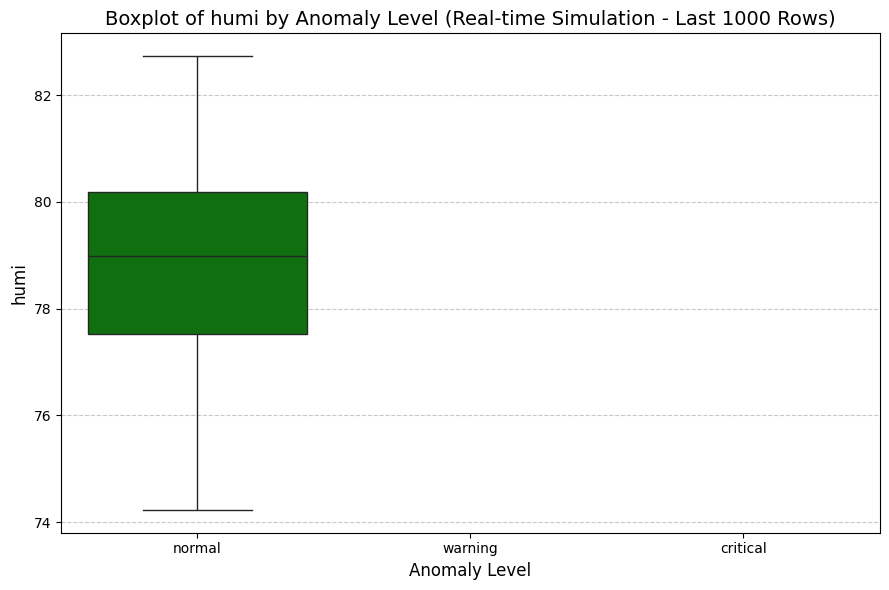

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


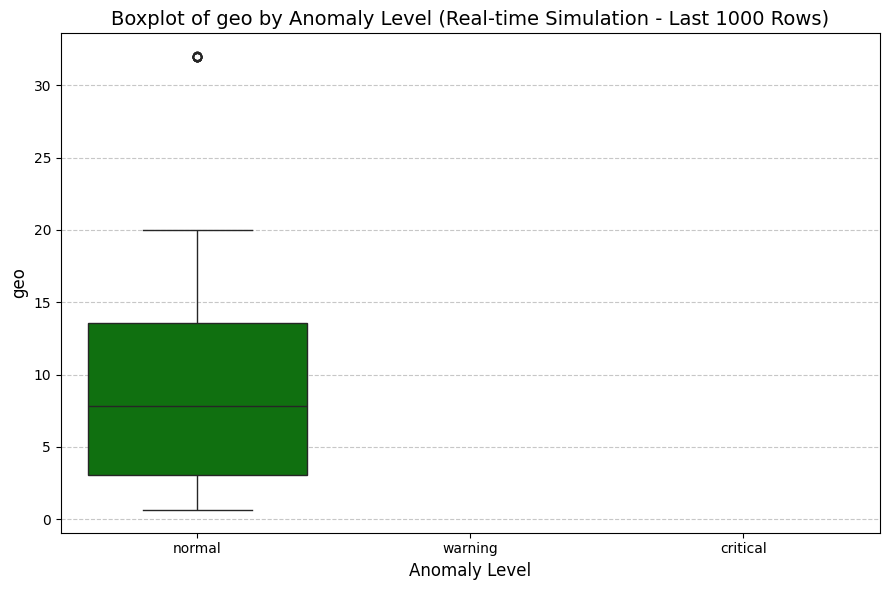

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


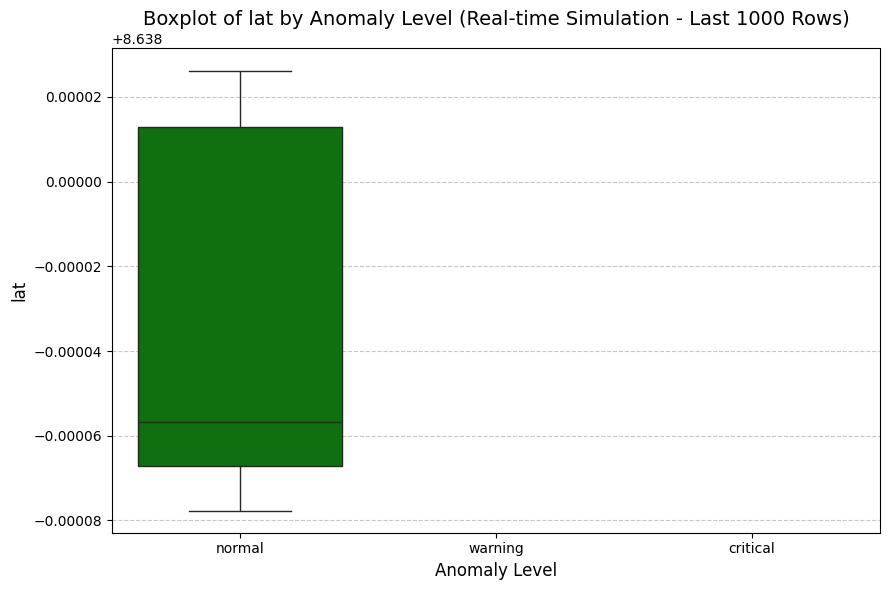

C:\Users\ahmad\AppData\Local\Temp\ipykernel_26036\384897452.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,


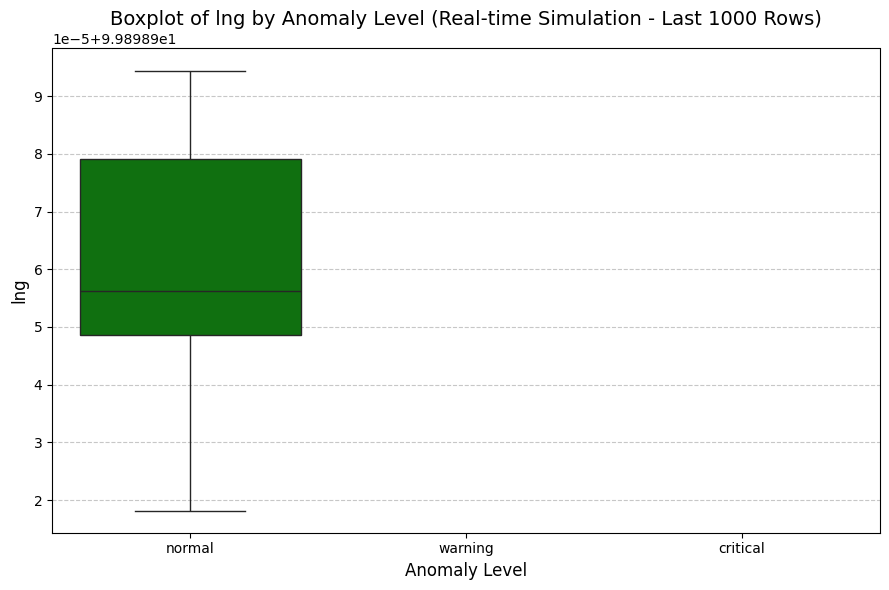


All Box Plots for Original Features successfully created!


In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import collections # สำหรับ deque
import matplotlib.pyplot as plt
import seaborn as sns

scaler = joblib.load('scaler2.save')
model = load_model('lstm_autoencoder_model2.h5', compile=False)

SEQUENCE_LENGTH = 30
numerical_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']
LAST_N_ROWS = 1000

df_full_data_source = pd.read_csv('../../data/devAll2_prepared.csv')
df_full_data_source['timestamp'] = pd.to_datetime(df_full_data_source['timestamp'])

df_full_data_source = df_full_data_source.sort_values(by=['timestamp']).reset_index(drop=True)

df_stream_data_source = df_full_data_source.tail(LAST_N_ROWS).reset_index(drop=True)

# --- hresholds ---
threshold_warning = 0.01
threshold_critical = 0.02

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'

# --- การเตรียมบัฟเฟอร์สำหรับแต่ละ devID ---
device_buffers = {} 
device_results = collections.defaultdict(list) 

print(f"--- Starting Real-time Anomaly Detection Simulation (Last {LAST_N_ROWS} Rows by Timestamp) ---")
print(f"Warning Threshold: {threshold_warning:.5f}")
print(f"Critical Threshold: {threshold_critical:.5f}")
print("-" * 50)

# ลูปผ่านข้อมูลเพื่อจำลองการรับค่าทีละแถว
current_dev_id_processing = None

for index, row in df_stream_data_source.iterrows():
    dev_id = row['devID']
    current_timestamp = row['timestamp']
    current_features = row[numerical_cols].values 
    
    if dev_id not in device_buffers:
        device_buffers[dev_id] = collections.deque(maxlen=SEQUENCE_LENGTH)

    scaled_features = scaler.transform(current_features.reshape(1, -1))[0]
    
    device_buffers[dev_id].append(scaled_features)
    
    if len(device_buffers[dev_id]) == SEQUENCE_LENGTH:
        input_sequence = np.array(device_buffers[dev_id]).reshape(1, SEQUENCE_LENGTH, len(numerical_cols))

        predicted_sequence = model.predict(input_sequence, verbose=0)

        error = np.mean(np.mean(np.square(input_sequence - predicted_sequence), axis=1), axis=1)[0]

        anomaly_level = classify_anomaly(error)

        print(f"  DevID: {dev_id}, Time: {current_timestamp}, Error: {error:.6f}, Level: {anomaly_level.upper()}")

        device_results['devID'].append(dev_id)
        device_results['timestamp'].append(current_timestamp)
        device_results['reconstruction_error'].append(error)
        device_results['anomaly_level'].append(anomaly_level)

        for col in numerical_cols:
            if col not in device_results:
                device_results[col] = []
            device_results[col].append(row[col])

print("\n--- Real-time Anomaly Detection Simulation Complete ---")

df_realtime_results = pd.DataFrame(device_results)

# --- การพลอตผลลัพธ์ (ถ้ามีข้อมูล) ---
if not df_realtime_results.empty:
    print("\n--- Summary of Real-time Anomaly Detection Results ---")
    print(df_realtime_results['anomaly_level'].value_counts())

    palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

    # 1. Distribution of Reconstruction Error (Real-time)
    plt.figure(figsize=(10, 6))
    sns.histplot(df_realtime_results['reconstruction_error'], bins=50, kde=True, color='purple', label='Reconstruction Error')
    plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
    plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
    plt.title('Distribution of Reconstruction Error (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Anomaly Level Counts (Real-time)
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df_realtime_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
    plt.title('Amount of Data in Each Anomaly Level (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Anomaly Level')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 3. Reconstruction Error Over Time with Anomaly Levels (Real-time)
    plt.figure(figsize=(15, 7))
    sns.scatterplot(
        data=df_realtime_results, x='timestamp', y='reconstruction_error',
        hue='devID', # เปลี่ยนเป็น hue='devID' เพื่อดูแยกแต่ละอุปกรณ์
        palette='tab10', # ใช้ palette ที่มีสีหลากหลายสำหรับ devID
        alpha=0.7, s=15,
        style='anomaly_level', # เพิ่ม style เพื่อแยกระดับ Anomaly
        markers={'normal': 'o', 'warning': '^', 'critical': 'X'}, # กำหนดรูปร่าง marker
        hue_order=sorted(df_realtime_results['devID'].unique()) # เรียง devID ใน legend
    )
    plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
    plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
    plt.title('Reconstruction Error over Time by Device ID (Real-time Simulation - Last 1000 Rows)')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    plt.xticks(rotation=45)
    plt.legend(title='Device ID / Anomaly Level', bbox_to_anchor=(1.05, 1), loc='upper left') # ขยับ legend
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # 4. Box Plot of Original Features by Anomaly Level (Real-time)
    print("\n--- Box Plots of Original Features by Anomaly Level (Real-time Simulation - Last 1000 Rows) ---")
    for feature in numerical_cols:
        plt.figure(figsize=(9, 6))
        sns.boxplot(data=df_realtime_results, x='anomaly_level', y=feature,
                    order=['normal', 'warning', 'critical'], palette=palette_anomaly)
        plt.title(f'Boxplot of {feature} by Anomaly Level (Real-time Simulation - Last 1000 Rows)', fontsize=14)
        plt.xlabel('Anomaly Level', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    print("\nAll Box Plots for Original Features successfully created!")

else:
    print("\nNo anomaly detection results were generated for the last 1000 rows. Check data availability and SEQUENCE_LENGTH.")